# Effect of the Atmosphere on Colour Coordinates

## Problem Statement /  Introduction

Aerosol attenuation in the atmosphere has a relatively weak spectral variation (weak compared to molecular absorption). However at high solar zenith angles, with the sun towards the horizon, the spectral irradiance on object at sea level differs substantially from the spectral irradiance with the sun at zero zenith angle.  The radiance from an object comprises at least three distinctly different components: the (1) reflected direct sunlight, (2) the reflected sky shine, and (3) the reflected earth shine.

The perceived colour of an object depends on the object's inherent colour as well as the irradiance spectrum. 
The spectral properties of the three irradiance components on an object at sea level vary dramatically with solar zenith angle.  When the sun is at zero zenith angle the sunlight is least attenuated (spectral variation is smaller), and the spectral properties of sky shine is similar to the direct sun irradiance. When the sun is near the horizon the direct sun irradiance shifts towards red, while the sky radiance shifts towards blue. Hence, depending on the orientation of the surface, the colour can shift towards red (facing the sun), towards blue (facing away from the sun), or anywhere in between depending on the ratio of direct sun to reflected sky.  It is reasonable to refer to a *shift in the colour balance of a scene* because of the solar zenith angle.  This shift is different for different object surface orientations in the scene, depending on the angle between the surface normal vector and the direction to the sun. 

Investigate the effect of the slow spectral variation in sunlight on the colour coordinates of a few objects through a selection of atmospheric conditions.  Ignore the reflected sky shine and reflected earth shine, consider only direct solar irradiance.  The data used in this investigation is in file `DP05.tgz` available at   
`https://github.com/NelisW/ComputationalRadiometry/blob/master/DataPackages/DP05.tgz?raw=true`. Study the `readme.txt` file for more information.

Do the analysis for the following samples: Lettuce, Skin Black, Skin White, Dark Green Leaf, Red Paint, Blue Nitrile Glove, and White Paper, being columns 2, 6, 7, 8, 9, 10, and 11 in the `samplesVis.txt` data file.

Modtran5 was used to calculate the direct solar irradiance at sea level, and the corresponding atmospheric transmittance to the sun. The Modtran atmospheres selected for this investigation are:

* Subarctic Summer (287 K, 75% RH at ground level) with no particulate aerosol (but with molecular scatter) with 310 km visibility. 
* Tropical (297 K, 75% RH at ground level) with a 75 km visibility (0 m/s wind speed) Desert aerosol model.
* US Standard 1976 (288 K, 46% RH at ground level) with a 23 km visibility Rural aerosol model. 
* Subarctic Summer (287 K, 75% RH at ground level) with a 5 km visibility Urban aerosol model.  

The main differences between the above atmospheres are in are in the aerosol models used; the differences in temperature, pressure and relative humidity vertical profiles have little effect on the visual band transmittance (in the infrared bands these differences are not negligible).  The solar irradiance was calculated for each of the above scenarios at zenith angles of $\{0, 45, 60, 80, 88\}$, where zero zenith angle is vertically up and 88 degrees is near the horizon.

1. Load and plot the samples' spectral reflectance. Show all the samples on the same graph. [2]

2. Load and plot the four atmosphere's spectral transmittance.  Show each atmosphere separately in its own plot, but show transmittance for all zenith angles for each atmosphere in the same plot.  Study the plots, compare the transmittance values for the different atmospheres and zenith angles and summarise the important similarities and differences. [4]

3. Load and plot the four atmosphere's spectral solar irradiance. Show each atmosphere separately in its own plot, but show irradiance for all zenith angles for each atmosphere in the same plot. Study the plots, compare the irradiance values for the different atmospheres and zenith angles and summarise the important similarities and differences. [4]

4. Plot the CIE coordinates of monochromatic colour from 380  nm to 720 nm. It should be a familiar horseshoe shape.  Find a colour version of the CIE diagram on the internet and confirm your calculations. [2]

5.  Present a complete mathematical derivation on how the CIE colour coordinates are calculated from spectral radiance. [3] 

6. Provide a description of how the CIE coordinates can be calculated from the RGB coordinates. [3]

7.  Calculate and plot a sequence of graphs (one graph for each atmosphere) showing the CIE colour coordinates for all the samples, showing the change in colour coordinates with different zenith angles.  The CIE plots must show the monochromatic horseshoe curve.  The idea is to demonstrate the change in colour with varying zenith angle.  [8]

8. Comment on the effect of zenith angle and visibility on the samples' apparent colour.  Describe the colour shifts in terms of colour names (i.e., colours tend to shift towards purple), rather than just giving coordinate numbers.  At which zenith angles does the colour shift become prominent?  Towards which colours do the shift converge for the different atmospheres?  Explain the differences in these shifts. [4]

9.  The picture `wallpic` shows a wall and some plants in sunshine and in shade.  The picture was taken in mid February in Pretoria at approximately 06:45.  The picture colour values are in the RGB coordinate system.  The atmospheric visibility is estimated to be considerably better than 23 km, with the sun elevation angle between 10 and 20 degrees.  A second picture is marked up with dots in the sunlit and shady parts of the image.  Calculate the CIE colour coordinates for a number of samples in the four identified regions. Compare the colour coordinates in the four regions and comment on the shift in colour coordinates. [10]


[40]


## Preparing the data

In [28]:
import numpy as np
import pandas as pd
from scipy.interpolate import  interp1d
import os

from IPython.display import display
from IPython.display import Image
from IPython.display import HTML

import pyradi.ryfiles as ryfiles
import pyradi.ryplot as ryplot
import pyradi.rymodtran as rymodtran
import pyradi.ryutils as ryutils
import pyradi.rychroma as rychroma
import pyradi.ryplanck as ryplanck

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import PIL 

#make pngs at required dpi
import matplotlib as mpl
mpl.rc("savefig", dpi=75)
mpl.rc('figure', figsize=(10,8))
       

In [29]:
#load the sample spectral data, to get wavelength vector for all the calcs
tgzFilename = 'DP05.tgz'
destinationDir = '.'
tarFilename = 'DP05.tar'
url = 'https://raw.githubusercontent.com/NelisW/pyradi/master/pyradi/data/EOSystemAnalysisDesign-Data/'
dlNames = ryfiles.downloadUntar(tgzFilename, url, destinationDir, tarFilename)
# print('filesAvailable are {}'.format(dlNames))

wavelength = ryfiles.loadColumnTextFile('samplesVis.txt', loadCol=[0],  comment='%')

samplesSelect = [2,6,7,8,9,10,11]
samples = ryfiles.loadColumnTextFile('samplesVis.txt', loadCol=samplesSelect,  comment='%')
# swavelength = samples[:,0]
samplesTxt=ryfiles.loadHeaderTextFile('samplesVis.txt', loadCol=samplesSelect, comment='%')
print(samplesTxt)


['Lettuce', 'Skin Black', 'Skin White', 'Dark Green Leaf', 'Red Paint', 'Blue Nitrile Glove', 'White Paper']


## CIE 1931 Colour Coordinates

Colour is an elusive property - different people perceive colour differently. Several colour standards have been proposed to minimise the effect of subjective interpretation.   A commonly used standard is the CIE 1931 tristimulus colour definitions of a 'standard human observer' (shown below).  In this diagram the monochromatic colours all lie on the horseshoe border.

The RGB system used in display screens are only capable of limited colour display, such as the triangle below.  The colours in the following graph are not rendered correctly, because the picture was prepared for display on an RGB display that cannot display all colours.  Similarly, most printers are unable to render all possible colours in the CIE 1931 system.

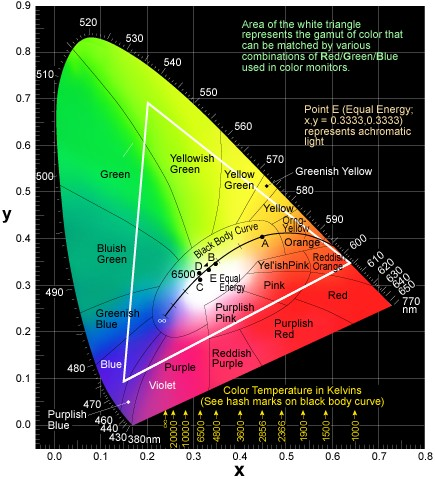

In [30]:
display(Image(filename="images/CIE 1931.png", width=400, height=400))

In the CIE 1931 colour system any colour can be expressed by two coordinates $x$ and $y$.  These coordinates describe only colour, not the value (darkness/intensity).  Two samples may have the same green colour, but at two different levels of brightness or darkness.

The tristimulus curves represent the colour response of the human eye.  It is interesting to note that the red colour stimulus has a significant component towards the blue part of the spectrum.

The tristimulus curves are used to calculate the $x$ and $y$ colour coordinates given the spectral radiance emanating from the surface of the object.

`ciebar[:,0]` is the wavelength vector, `ciebar[:,1]` is the x-bar vector, etc.

(343L, 4L)


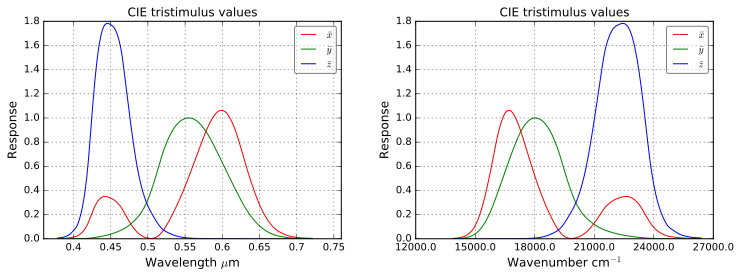

In [31]:
cietriplt = ryplot.Plotter(1, 1,2, figsize=(12,4))
ciebar = rychroma.loadCIEbar(1e4/wavelength, stype='wn')
print(ciebar.shape)
cietriplt.plot(2, 1e4/wavelength, ciebar[:,1:4], "CIE tristimulus values",
        r'Wavenumber cm$^{-1}$', r'Response', plotCol = ['r','g','b'],
        label=['$\\bar{x}$', '$\\bar{y}$', '$\\bar{z}$'],legendAlpha=0.5,maxNX=5);
ciebar = rychroma.loadCIEbar(wavelength, stype='wl')
cietriplt.plot(1, wavelength, ciebar[:,1:4], "CIE tristimulus values",
        r'Wavelength $\mu$m', r'Response', plotCol = ['r','g','b'],
        label=['$\\bar{x}$', '$\\bar{y}$', '$\\bar{z}$'],legendAlpha=0.5);



## Conversion from spectral radiance to CIE Colour coordinates

To calculate the xyY color coordinates of a color given the spectrum, proceed as follows:
\begin{eqnarray}
X(T)&=&\int_0^\infty \bar{x}_\lambda E_\lambda d\lambda,\\
Y(T)&=&\int_0^\infty \bar{y}_\lambda E_\lambda d\lambda, \;\; {\rm and}\\
Z(T)&=&\int_0^\infty \bar{z}_\lambda E_\lambda d\lambda,
\end{eqnarray}
where $\bar{x}_\lambda$, $\bar{y}_\lambda$, and $\bar{z}_\lambda$ are the color-matching functions of the CIE standard colorimetric observer and $E$ are the spectral the Modtran irradiance values. Note that any scale factors normalises out in the division.   The xyz  chromaticity color coordinates can then be calculated by
\begin{eqnarray}
x&=&\frac{X}{X+Y+Z},\\
y&=&\frac{Y}{X+Y+Z}, \;\; {\rm and}\\
z&=&\frac{Z}{X+Y+Z} = 1-x-y,
\end{eqnarray}
where $x$ and $y$ define the color coordinates  in the xy chromaticity diagram.  



## Conversion from RGB to CIE coordinates



From [wikipedia](http://en.wikipedia.org/wiki/CIE_1931_color_space) the conversion between RGB and CIE coordinates are given by:
    
The numbers in the conversion matrix below are exact, with the number of digits specified in CIE standards.[10]

\begin{equation}
\begin{bmatrix}X\\Y\\Z\end{bmatrix}=\frac{1}{b_{21}} \begin{bmatrix} b_{11}&b_{12}&b_{13}\\ b_{21}&b_{22}&b_{23}\\ b_{31}&b_{32}&b_{33} \end{bmatrix} \begin{bmatrix}R\\G\\B\end{bmatrix}=\frac{1}{0.17697} \begin{bmatrix} 0.49&0.31&0.20\\ 0.17697&0.81240&0.01063\\ 0.00&0.01&0.99 \end{bmatrix} \begin{bmatrix}R\\G\\B\end{bmatrix} 
\end{equation}

While the above matrix is exactly specified in standards, going the other direction uses an inverse matrix that is not exactly specified, but is approximately:

\begin{equation}
\begin{bmatrix}R\\G\\B\end{bmatrix} = \begin{bmatrix} 0.41847 & -0.15866 & -0.082835\\ -0.091169 & 0.25243 & 0.015708\\ 0.00092090 & -0.0025498 & 0.17860 \end{bmatrix} \cdot \begin{bmatrix}X\\Y\\Z\end{bmatrix}
\end{equation}
    
If the RGB coordinates of a pixel picture is known it can be converted to the CIE $(x,y)$ coordinates, using the transformation shown above.  Note however, that the camera built in white balance adjustment and the spectral response of the camera detector will affect the RGB colour coordinates. Hence, this means to determine colour coordinates is inaccurate at best!

The analysis shown below, studies an opportunistic picture taken with a Samsung Note 4 with the standard camera software on automatic white balance correction.  The picture was taken in mid February in Pretoria at approximately 06:45.  The atmospheric visibility is estimated to be considerably better than 23 km, with the sun elevation angle between 10 and 20 degrees.  The picture contains green foliage and a brick wall, both in the shade and in direct sunlight.  The analysis shows three 'calibration' points to verify the coordinate system plus a 12 or 18 points on each of the test regions in the image.



In [32]:
# def XYZRGB(r,g,b):
#     """Convert from CIE RGB coordinates to CIE (x,y) coordinates
#     https://en.wikipedia.org/wiki/CIE_1931_color_space
#     """
#     matr = np.asarray([[0.49,0.31,0.20],[0.17697,0.81240,0.01063],[0.00,0.01,0.99]])
#     vec=np.asarray([r,g,b])
#     XYZ = 5.6507 * matr.dot(vec)
#     x = XYZ[0] / np.sum(XYZ)
#     y = XYZ[1] / np.sum(XYZ)
#     return x,y


## Atmospheric Definitions

Modtran5 was used to calculate the direct solar irradiance at sea level, and the corresponding atmospheric transmittance to the sun.
The standard Modtran atmospheres selected for this investigation are:

* Subarctic Summer (287 K, 75% RH at ground level) with no particulate aerosol (but with molecular scatter) with 310 km visibility. 
* Tropical (297 K, 75% RH at ground level) with a 75 km visibility (0 m/s wind speed) Desert aerosol model.
* US Standard 1976 (288 K, 46% RH at ground level) with a 23 km visibility Rural aerosol model. 
* Subarctic Summer (287 K, 75% RH at ground level) with a 5 km visibility Urban aerosol model.  

The main differences between the above atmospheres are in are in the aerosol models used; the differences in temperature, pressure and relative humidity vertical profiles have little effect on the visual band transmittance (in the infrared bands these differences are not negligible).  

The solar irradiance was calculated for each of the above scenarios at zenith angles of $\{0, 45, 60, 80, 88\}$, where zero zenith angle is vertically up and 88 degrees is near the horizon.


The data were pre-calculated and stored in a directory structure with the following names:

In [33]:
scenarios = ['Subarctic Summer  No Aerosol','Tropical Desert Aerosol','US Standard 1976 23 km Rural','Subarctic Summer 5km Urban']
angles = ['00','45','60','80','88']

## Modtran data

The data are stored nested lists. The first index into the list is the scenario index, with the second index being the zenith angle index.  
-  The atmospheric transmittance data are stored in the `tau[scenario][angle]` nested list.  
-  The irradiance on ground level are stored in the `irr[scenario][angle]` nested list.
-  The (external) irradiance outside (above) the atmosphere are stored in the `ire[scenario][angle]` nested list.


The Modtran data are in wavenumber spectral units at 1 cm$^{-1}$ resolution --- which is too fine for these calculations. When reading in the transmittance and solar irradiance data the values are first convolved with a top-hat signal to average out the fine spectral detail from 1 cm$^{-1}$ to 40 cm$^{-1}$.   The data is then converted to wavelength spectral units. Finally, the data is interpolated to the wavelength vector used in the samples and CIE tristimulus curves.

Load the Modtran data from the tape7 files: transmittance, irradiance through the atmosphere and irradiance for no atmosphere.

<font color="red">Note that the Modtran data are given in wavenumber terms:  frequency in wavenumbers and spectral density in terms of wavenumbers.</font>  We want to work in wavelength domain, so convert both the spectral and the density values from wavenumber domain to wavelength domain.

In [34]:
tau = []
irr = []
ire = []
for i, scenario in enumerate(scenarios):
    tauA = []
    irrA = []
    ireA = []
    for j, (angle, pcol) in enumerate(zip(angles,['y', 'r','b', 'g', 'k'])):
        filename = '.' + os.path.join(os.path.sep, 'atmo-colour', scenario, angle, 'tape7')
#         print(filename, '{}'.format(angle))
        
        #load the modtran tape7 file: wavenumber, transmittance, E-through-atmo, E-no-atmo
        tape7 = rymodtran.loadtape7(filename, ['FREQ', 'TRANS', 'SOL_TR', 'SOLAR'] )
        
        # convolve transmittance and irradiance from 1cm-1 to 40 cm-1, corresponds to cie increment
        tape7[:,1],  windowfn = ryutils.convolve(tape7[:,1], 1, 1, 40)
        tape7[:,2],  windowfn = ryutils.convolve(tape7[:,2], 1, 1, 40)
        tape7[:,3],  windowfn = ryutils.convolve(tape7[:,3], 1, 1, 40)
        
        #convert irradiance from W/(cm2.cm-1) to W/(m2.um)
        wl, E = ryutils.convertSpectralDensity(tape7[:,0], tape7[:,2],'nl')
        tape7[:,2] = 1.0e4 * E.reshape(-1,)
        wl, E = ryutils.convertSpectralDensity(tape7[:,0], tape7[:,3],'nl')
        tape7[:,3] = 1.0e4 * E.reshape(-1,)
        
        #interpolate modtran data to samples spectral range
        #first construct the interpolating function hen call the function on modtran data
        interpfunT = interp1d(wl, tape7[:,1], bounds_error=False, fill_value=0.0)
        T = interpfunT(ciebar[:,0] )
        interpfunE = interp1d(wl, tape7[:,2], bounds_error=False, fill_value=0.0)
        E = interpfunE(ciebar[:,0] )
        interpfunEx = interp1d(wl, tape7[:,3], bounds_error=False, fill_value=0.0)
        Ex = interpfunEx(ciebar[:,0] )
        tauA.append(T)
        irrA.append(E)
        ireA.append(Ex)
    tau.append(tauA)
    irr.append(irrA)
    ire.append(ireA)
# print(len(tau),len(tau[0]))
print(ire[0][0].shape)
print(ciebar.shape)

(343L,)
(343L, 4L)


The Modtran data represent a two-dimensional grid of scenarios and zenith angles.  In the review below the data are graphically compared along each of the two dimensions to demonstrate the effect of the variation in each of the dimensions.

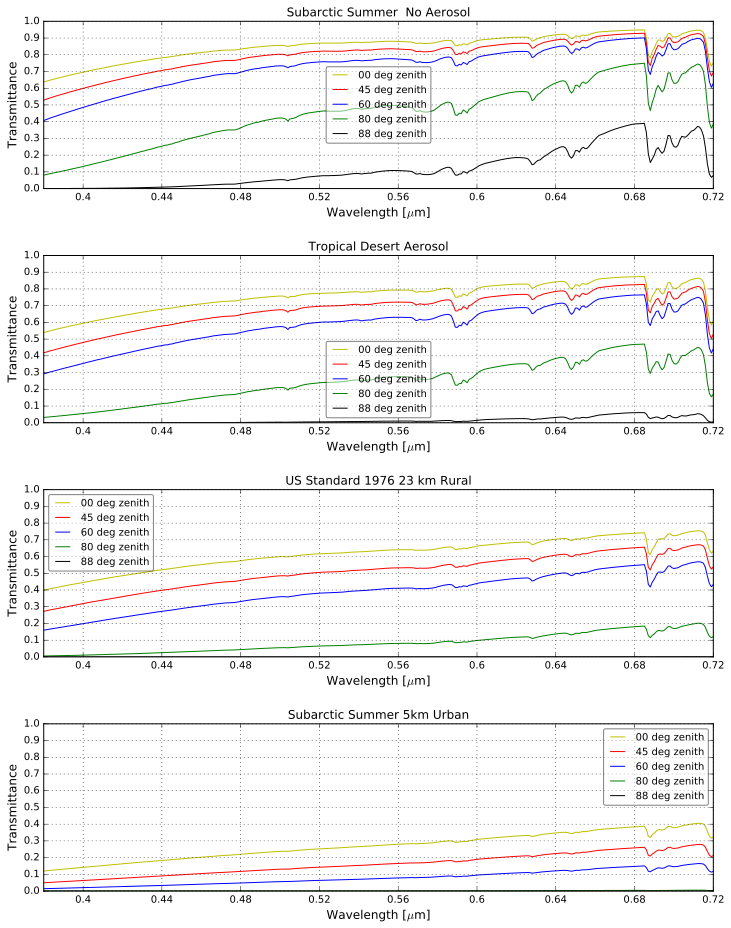

In [35]:
mT = ryplot.Plotter(1, 4, 1,"",figsize=(12,16))
for i, scenario in enumerate(scenarios):
    for j, (angle, pcol) in enumerate(zip(angles,['y', 'r','b', 'g', 'k'])):
        mT.plot(i+1, ciebar[:,0] , tau[i][j], scenario,"Wavelength [$\mu$m]", "Transmittance",
               label=['{} deg zenith'.format(angle)],plotCol=pcol, legendAlpha=0.5, pltaxis=[0.38,0.72, 0, 1])

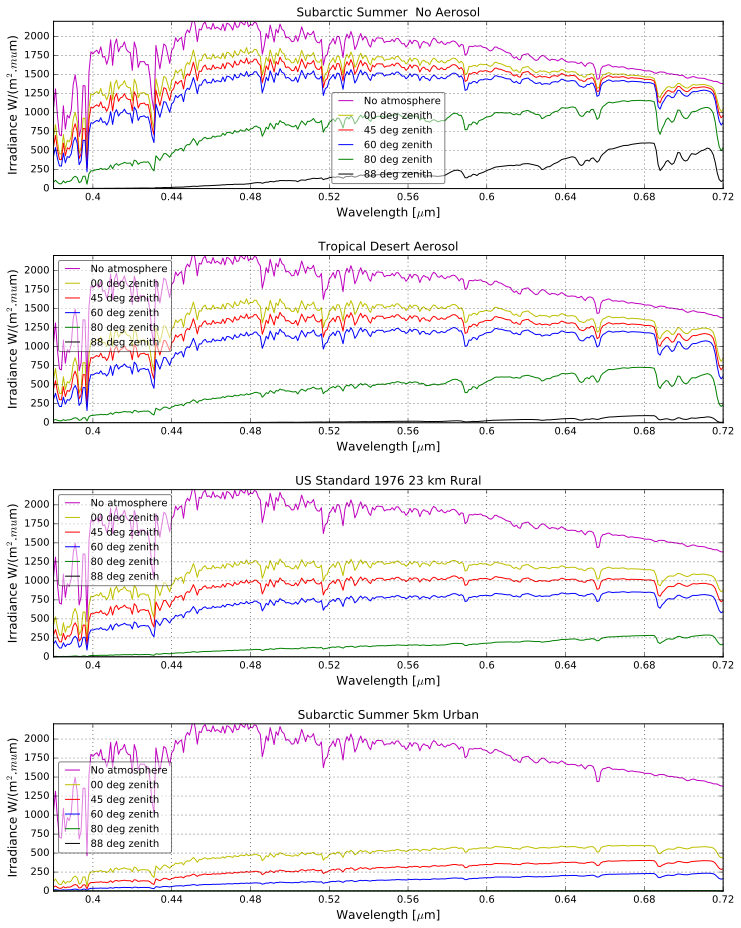

In [36]:
mE = ryplot.Plotter(2, 4, 1,"",figsize=(12,16))
for i, scenario in enumerate(scenarios):
    mE.plot(i+1, ciebar[:,0] , ire[i][0], scenario,"Wavelength [$\mu$m]", "Irradiance W/(m$^2$.$mu$m)",
           label=['No atmosphere'],plotCol='m', legendAlpha=0.5, pltaxis=[0.38,0.72, 0, 2200])
    for j, (angle, pcol) in enumerate(zip(angles,['y', 'r','b', 'g', 'k'])):
        mE.plot(i+1, ciebar[:,0] , irr[i][j], scenario,"Wavelength [$\mu$m]", "Irradiance W/(m$^2$.$mu$m)",
               label=['{} deg zenith'.format(angle)],plotCol=pcol, legendAlpha=0.5, pltaxis=[0.38,0.72, 0, 2200])

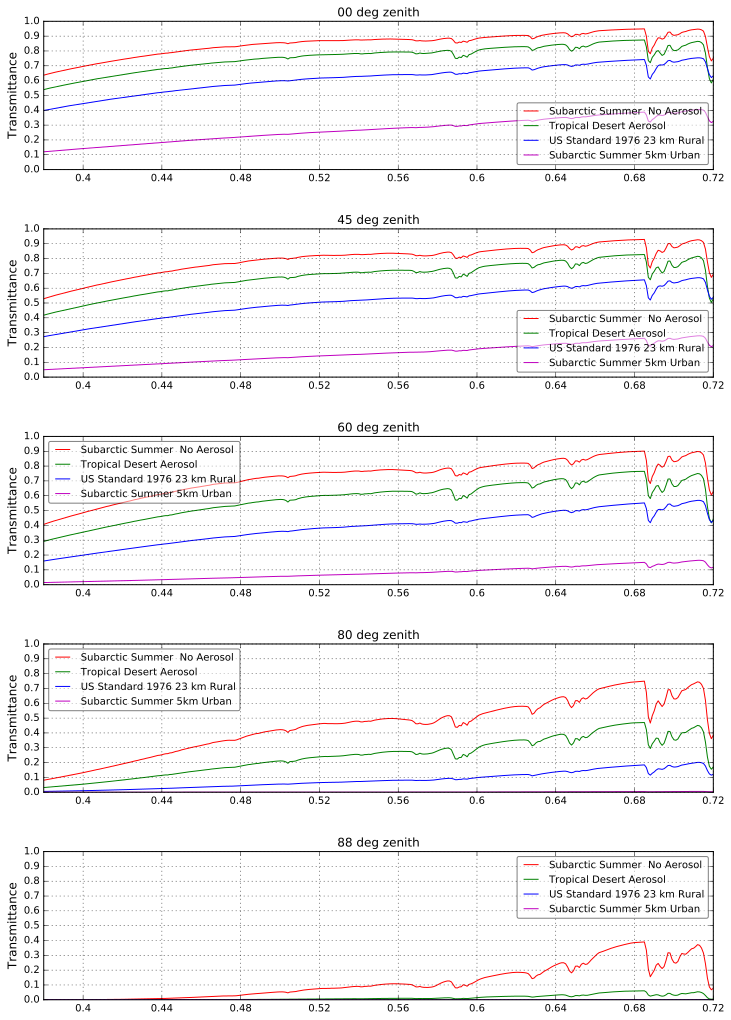

In [37]:
mT = ryplot.Plotter(1, 5, 1,"",figsize=(12,18))
for j, angle in enumerate(angles):
    for i, (scenario, pcol) in enumerate(zip(scenarios,['r', 'g','b','m'])):
        mT.plot(j+1, ciebar[:,0] , tau[i][j], '{} deg zenith'.format(angle), '', "Transmittance",
               label=['{}'.format(scenario)],plotCol=pcol, legendAlpha=0.5, pltaxis=[0.38,0.72, 0, 1])

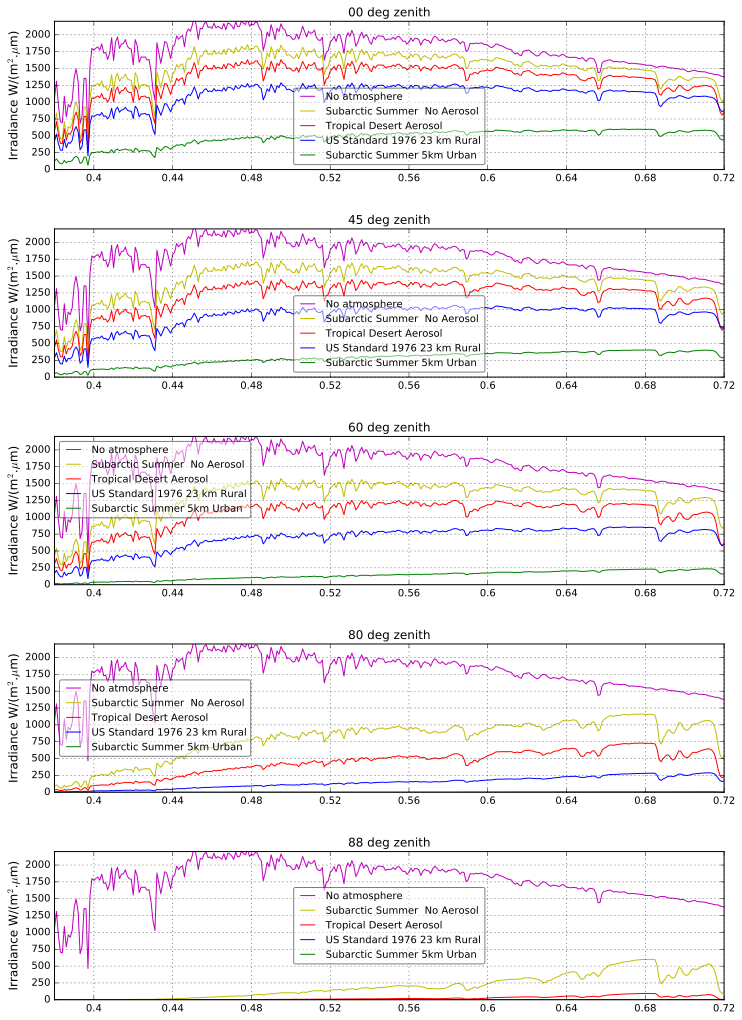

In [38]:
mE = ryplot.Plotter(2, 5, 1,"",figsize=(12,18))
for j, angle in enumerate(angles):
    mE.plot(j+1, ciebar[:,0] , ire[i][0], scenario,"Wavelength [$\mu$m]", "Irradiance W/(m$^2$.$mu$m)",
           label=['No atmosphere'],plotCol='m', legendAlpha=0.5, pltaxis=[0.38,0.72, 0, 2200])
    for i, (scenario, pcol) in enumerate(zip(scenarios,['y', 'r','b', 'g', 'k'])):
        mE.plot(j+1, ciebar[:,0] , irr[i][j], '{} deg zenith'.format(angle), '', "Irradiance W/(m$^2$.$\mu$m)",
               label=['{}'.format(scenario)],plotCol=pcol, legendAlpha=0.5, pltaxis=[0.38,0.72, 0, 2200])

It is evident that the solar zenith angle significantly affects the transmittance and solar irradiance for any given atmosphere.  This effect is more pronounced at zenith angles exceeding 60 degrees.

Not surprising, the aerosol content in the atmosphere also affects the transmittance and solar irradiance even for vertical paths.

## Material samples

The samples illuminated by the sunlight 'filtered' by the atmosphere were measured with a spectroradiometer, illuminating the sample with a bright light at short distance.  The samples are 
'Lettuce', 'Skin Black', 'Skin White', 'Dark Green Leaf',u'Red Paint', 'Blue Nitrile Glove' (latex-like surgical glove), and 'White Paper'.  The samples' diffuse reflection spectra The fruit samples all demonstrated considerable light propagation deeper into the fruit. The blue glove was located on a Spectralon white reference (note the considerable 'white' reflectance beyond 0.55~$\mu$m).

The wavelength vector used in the sample data is used in all subsequent spectral calculations; all other spectral data are interpolated to the values in this vector.

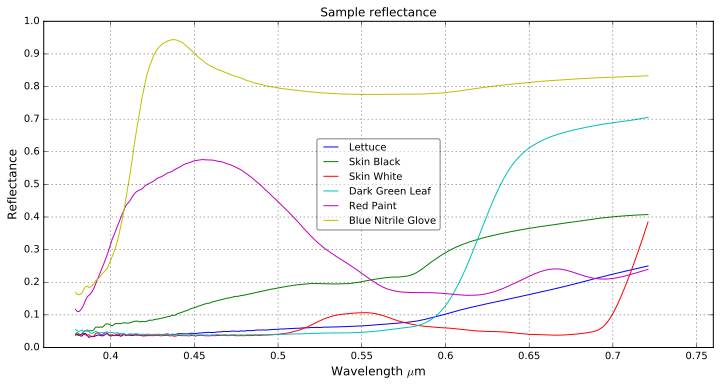

In [39]:
smpleplt = ryplot.Plotter(1, 1, 1, figsize=(12,6))
smpleplt.plot(1, wavelength, samples[:,1:], "Sample reflectance", r'Wavelength $\mu$m',
            r'Reflectance', label=samplesTxt,legendAlpha=0.5);

# print(samples)

First calculate the samples' colour coordinates for no atmospheric attenuation and a 5900 K source temperature, i.e., the intrinsic daylight colour coordinates.  These colour coordinates will serve as reference as the 'perfect' colour.  In all graphs the filled circular marker represent the 'true' colour coordinate of the sample.

In the three blocks of code below,   
-  `(xi,yi)` represent the intrinsic sample colour (no atmosphere, 5900 K source).  
-  `(xs,ys)` represent the apparent sample colour (with atmosphere, Modtran irradiance through the atmosphere).  
-  `(xm,ym)` represent monochromatic colour (no atmosphere, single frequency source)  


In [40]:
xi = np.zeros((samples.shape[1]))
yi = np.zeros((samples.shape[1]))
# ciebar = rychroma.loadCIEbar(samples[:,1], stype='wl')

for iSmpl in range(samples.shape[1]):
    smplfn = interp1d(samples[:,0],samples[:,iSmpl], bounds_error=False)
    [ xi[iSmpl], yi[iSmpl], Y]=\
        rychroma.chromaticityforSpectralL(ciebar[:,0] ,
        ire[0][0].reshape(-1,1),
        ciebar[:,1], ciebar[:,2], ciebar[:,3])               

Then calculate the samples' colour coordinates for the collection of scenarios and zenith angles.

In [41]:
xs = np.zeros((samples.shape[1],len(irr),len(irr[0])))
ys = np.zeros((samples.shape[1],len(irr),len(irr[0])))
for iSmpl in range(samples.shape[1]):
    for i, scenario in enumerate(scenarios):
        for j, angle in enumerate(angles):
            [ xs[iSmpl,i,j], ys[iSmpl,i,j], Y]=\
                rychroma.chromaticityforSpectralL(ciebar[:,0],
                (samples[:,iSmpl].reshape(-1, 1)*(irr[i][j]).reshape(-1, 1)),
                ciebar[:,1], ciebar[:,2], ciebar[:,3])               

Next calculate the colour coordinates for monochromatic wavelengths (the horseshoe boundary).

In [42]:
xm = np.zeros(wavelength.shape)
ym = np.zeros(wavelength.shape)
#create a series of data points with unity at specific wavelength
for iWavel in range(wavelength.shape[0]):
    monospectrum = np.zeros(wavelength.shape)
    monospectrum[iWavel] = 1
    #calc xy for single mono wavelength point
    [xm[iWavel],ym[iWavel],Y] = rychroma.chromaticityforSpectralL(ciebar[:,0],
            monospectrum, ciebar[:,1], ciebar[:,2], ciebar[:,3])

This function plots the colour coordinates for collections of scenarios or collections of zenith angles.  Two plots are shown side by side; the right plot is a zoomed in version of the left plot.

In [43]:
def plotCIECoords(samples, xs, ys, scenarios, angles, scenarioSel, angleSel):
    ciexyplt = ryplot.Plotter(4, 1, 2, figsize=(12,6))

    styleSource=['*', '<', '^', 'v','>']
    styleSample=['r--', 'g-.', 'y-', 'g-', 'b-', 'k-', 'm']
    nulCC = np.asarray([0.])  
    
    for k,pltaxis in enumerate([[0, 0.9, 0, 0.9],[0.2, 0.75, 0.25, 0.5]]):

        if scenarioSel >= 0:
            for j, angle in enumerate(angles):
                legend=['{} deg zenith'.format(angle)]
                ciexyplt.plot(k+1,nulCC,nulCC,
                        "CIE chromaticity diagram {}".format(scenarios[scenarioSel]), r'x',r'y',
                        ['w-'],label=legend,legendAlpha=0.5,
                        pltaxis=pltaxis, markers=[styleSource[j]])
        if angleSel >= 0:
            for i, scenario in enumerate(scenarios):
                legend=['{} '.format(scenario)]
                ciexyplt.plot(k+1,nulCC,nulCC,
                        "CIE chromaticity diagram {} deg zenith".format(angles[angleSel]), r'x',r'y',
                        ['w-'],label=legend,legendAlpha=0.5,
                        pltaxis=pltaxis, markers=[styleSource[i]])        
        
        ciexyplt.plot(k+1,nulCC,nulCC,'', '','', ['w-'],
                label=['True colour'],legendAlpha=0.5,
                pltaxis=pltaxis, markers=['o'])

        ciexyplt.resetPlotCol()
        #plot monochromatic horseshoe
        ciexyplt.plot(k+1, xm, ym, plotCol=['k-'],pltaxis=pltaxis)
        
        # plot achromatic point - no colour
        ciexyplt.plot(1, np.asarray([0.333, 0.333]), np.asarray([0.283, 0.383]), plotCol=['k-'])
        ciexyplt.plot(1, np.asarray([0.283, 0.383]), np.asarray([0.333, 0.333]), plotCol=['k-'])
        ciexyplt.plot(2, np.asarray([0.333, 0.333]), np.asarray([0.283, 0.383]), plotCol=['k-'])
        ciexyplt.plot(2, np.asarray([0.283, 0.383]), np.asarray([0.333, 0.333]), plotCol=['k-'])
        
        #plot chromaticity loci for samples
        for iSmpl in range(samples.shape[1]):
            label=samplesTxt[iSmpl]
            ciexyplt.plot(k+1,xi[iSmpl],yi[iSmpl],'', '','', plotCol=[styleSample[iSmpl]],
                    pltaxis=pltaxis, markers=['o'])
            if scenarioSel >= 0:
                ciexyplt.plot(k+1,xs[iSmpl,scenarioSel,:],ys[iSmpl,scenarioSel,:],legendAlpha=0.5,
                        pltaxis=pltaxis,label=[label], plotCol=[styleSample[iSmpl]])
            if angleSel >= 0:
                ciexyplt.plot(k+1,xs[iSmpl,:,angleSel],ys[iSmpl,:,angleSel],legendAlpha=0.5,
                        pltaxis=pltaxis,label=[label], plotCol=[styleSample[iSmpl]])
                

        #plot source markers
        for iSmpl in range(samples.shape[1]):
            if scenarioSel >= 0:
                for j, angle in enumerate(angles):
                    ciexyplt.plot(k+1,xs[iSmpl,scenarioSel,j],ys[iSmpl,scenarioSel,j],
                            "CIE chromaticity diagram {}".format(scenarios[scenarioSel]), r'x',r'y',
                            [styleSample[iSmpl]],label='',
                            pltaxis=pltaxis, markers=[styleSource[j]])
            if angleSel >= 0:
                for i, scenario in enumerate(scenarios):
                    ciexyplt.plot(k+1,xs[iSmpl,i,angleSel],ys[iSmpl,i,angleSel],
                            "CIE chromaticity diagram {} deg zenith".format(angles[angleSel]), r'x',r'y',
                            [styleSample[iSmpl]],label='',
                            pltaxis=pltaxis, markers=[styleSource[i]])

In the graphs below the sample's intrinsic daylight colour (5900 K source and no atmosphere) is a circle marker to serve as a reference.  The different variations of zenith angles or scenarios are indicted with star or triangle markers.

The first set of graphs plot the colour coordinates for the scenarios for the full set of zenith angles.

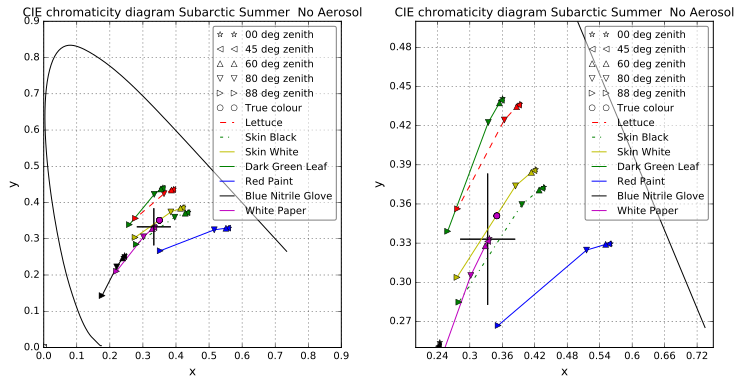

In [44]:
plotCIECoords(samples, xs, ys, scenarios, angles, 0, -1 )

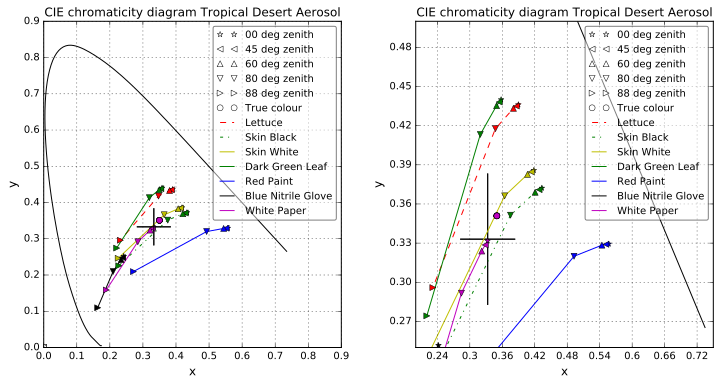

In [45]:
plotCIECoords(samples, xs, ys, scenarios, angles, 1, -1 )

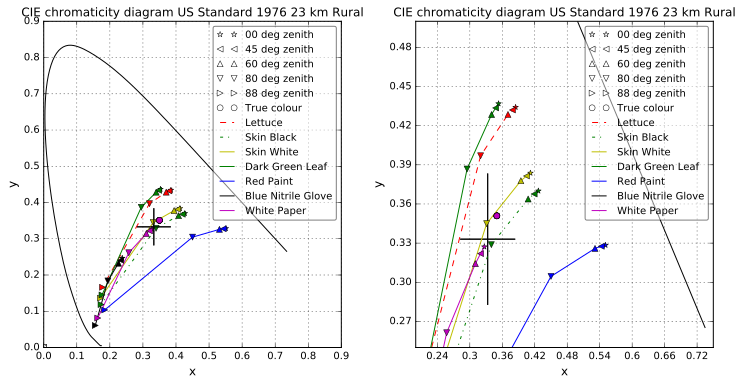

In [46]:
plotCIECoords(samples, xs, ys, scenarios, angles, 2, -1 )

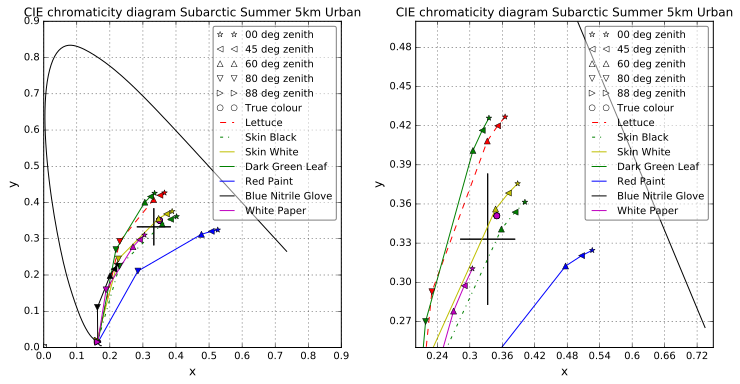

In [47]:
plotCIECoords(samples, xs, ys, scenarios, angles, 3, -1 )

The second set of graphs plot the colour coordinates for given zenith angles for the full set of scenarios.

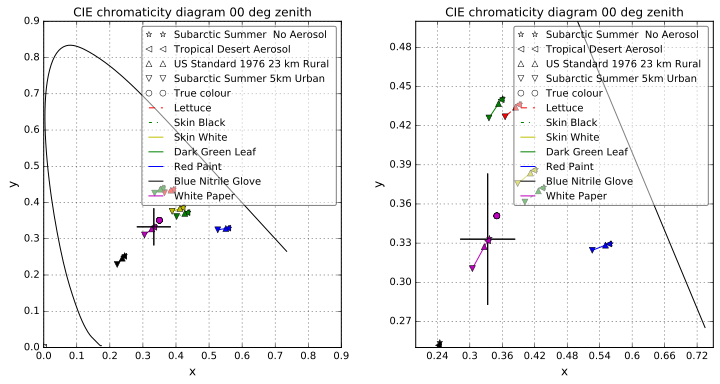

In [48]:
plotCIECoords(samples, xs, ys, scenarios, angles, -1, 0 )

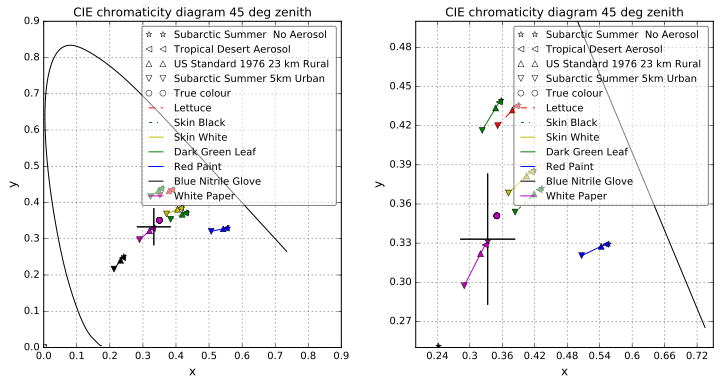

In [49]:
plotCIECoords(samples, xs, ys, scenarios, angles, -1, 1 )

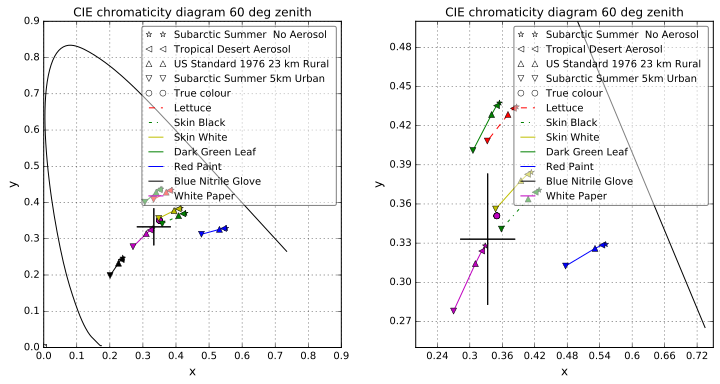

In [50]:
plotCIECoords(samples, xs, ys, scenarios, angles, -1, 2)

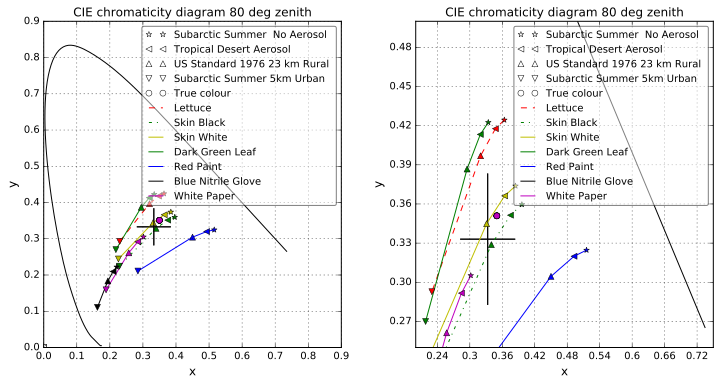

In [51]:
plotCIECoords(samples, xs, ys, scenarios, angles, -1, 3)

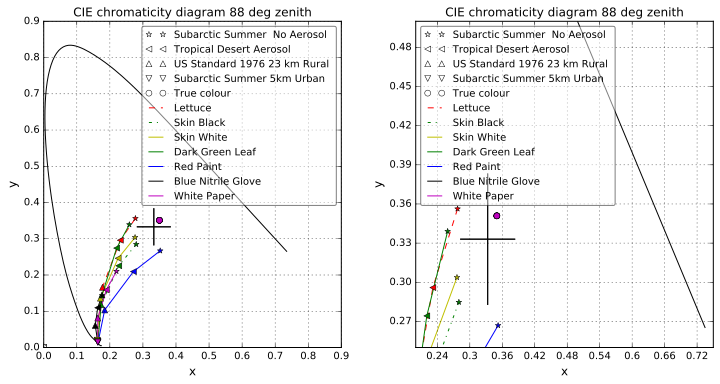

In [52]:
plotCIECoords(samples, xs, ys, scenarios, angles, -1, 4)

From the colour coordinate graphs the following observations arise:  


* The colour coordinates shift towards yellow/red in the presence of atmospheres, even for 310 km visibility molecular scattering.  

* The colour coordinates shift towards red at large zenith angles (near the horizon).  

* The shift is small for low visibility atmospheres and at sun zenith angles below 45 deg.

* The shift is progressively worse at larger zenith angles and/or lower visibility.

* In the worst case of low visibility (5 km Urban) and large zenith angles the shift is so severe that all samples are essentially perceived as red in colour.

## Colour shift in an image

In [53]:
# to analyse and plot a single picture
def singlePictureAnalysis(picture,calpts,smplpts,colset,labels,cropwin,doAchro=True,doRGB=True):

    #prepare for plotting
    p = ryplot.Plotter(1,1,1,figsize=(15.7,8.5))
    q = ryplot.Plotter(2,1,2,figsize=(12,6))

    # plot monochromatic horseshoe
    q.plot(1, xm, ym, '', '$x$', '$y$', plotCol=['k-'], pltaxis=[0.,0.9,0.,0.9])
    q.plot(2, xm, ym, '',' $x$', '$y$', plotCol=['k-'], pltaxis=cropwin)

    if doAchro:
        # plot achromatic point - no colour
        q.plot(1, np.asarray([0.333, 0.333]), np.asarray([0.283, 0.383]), plotCol=['k-'])
        q.plot(1, np.asarray([0.283, 0.383]), np.asarray([0.333, 0.333]), plotCol=['k-'])
        q.plot(2, np.asarray([0.333, 0.333]), np.asarray([0.283, 0.383]), plotCol=['k-'])
        q.plot(2, np.asarray([0.283, 0.383]), np.asarray([0.333, 0.333]), plotCol=['k-'])

    if doRGB:
        #plot the CIE RGB triangle: R, G, B
        rgbTri = np.asarray([[255,0,0],[0,255,0],[0,0,255]])    
        xy = rychroma.CIErgbCIExy(rgbTri)
        for i,ch in zip([0,1,2],['R','G','B']):
            q.plot(1, np.asarray([xy[i,0], xy[(i+1)%3,0]]), np.asarray([xy[i,1], xy[(i+1)%3,1]]), plotCol=['k-'])
            q.plot(2, np.asarray([xy[i,0], xy[(i+1)%3,0]]), np.asarray([xy[i,1], xy[(i+1)%3,1]]), plotCol=['k-'])
            q.getSubPlot(1).text(xy[i,0], xy[i,1],ch)
        
    p.showImage(1, picture, ptitle='');
    # prepare for filled markers
    markers = ryplot.Markers(markerfacecolor='k', marker='.')
    markersxy = ryplot.Markers(markerfacecolor='k', marker='.')

    # plot / record the markers for the calibration samples
    for i,point in enumerate(calpts):
        markers.add(point[0],point[1],markersize=20, markerfacecolor=colset[i], 
            fillstyle='full', markerfacecoloralt='k', marker='*')
        xy = rychroma.CIErgbCIExy(np.asarray([picture[point[1],point[0],0], 
                          picture[point[1],point[0],1], 
                          picture[point[1],point[0],2]]))
        markersxy.add(xy[0,0],xy[0,1],markersize=10, markerfacecolor=colset[i], marker='*')
        

    # plot / record the markers for the test samples
    for i,item in enumerate(smplpts):
        q.plot(1,np.asarray([0.]),np.asarray([0.]),plotCol=colset[i],label=[labels[i]])
        q.plot(2,np.asarray([0.3]),np.asarray([0.45]),plotCol=colset[i],label=[labels[i]])
        for point in item:
            markers.add(point[0],point[1],markersize=20, markerfacecolor=colset[i], 
                        fillstyle='full', markerfacecoloralt='k')
            xy = rychroma.CIErgbCIExy(np.asarray([picture[point[1],point[0],0], 
                                              picture[point[1],point[0],1], 
                                              picture[point[1],point[0],2]]))
            markersxy.add(xy[0,0],xy[0,1],markersize=10, markerfacecolor=colset[i])

    #plot the markers
    markers.plot(p.getSubPlot(1))
    markersxy.plot(q.getSubPlot(1))
    markersxy.plot(q.getSubPlot(2))



(1226L, 2264L, 3L)


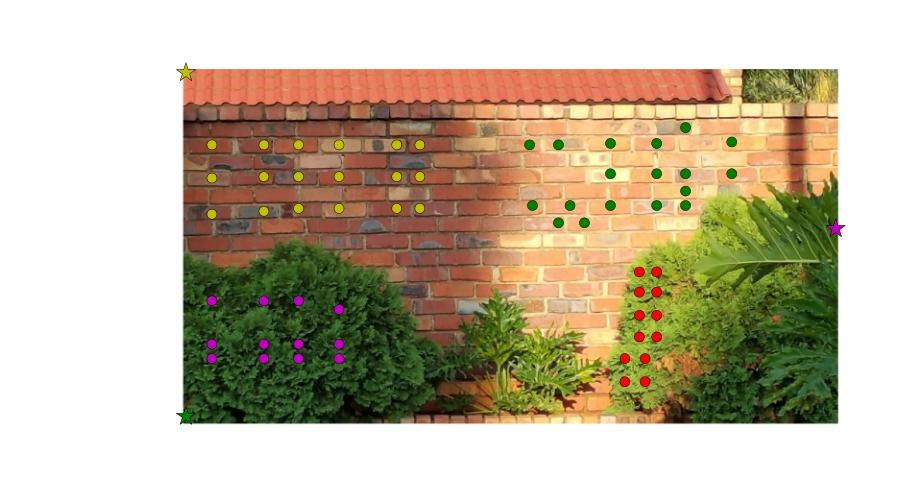

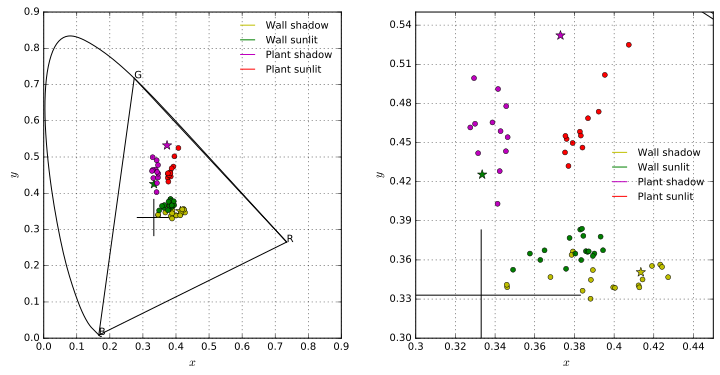

In [56]:
# define the pixel sample coordinates
colset = ['y','g','m','r']
labels = ['Wall shadow', 'Wall sunlit','Plant shadow','Plant sunlit']
smplpts = [[[100,260],[280,260], [400,260], [540,260], [740,260], [820,260],
[100,375],[280,370], [400,370], [540,370], [740,370], [820,370],
[100,500],[280,490], [400,480], [540,480], [740,480], [820,480],],[
[1200,260],[1300,260], [1480,255], [1640,255], [1740,200], [1900,250],
[1340,470],[1210,470], [1480,360], [1640,360], [1740,360], [1900,360],
[1300,530],[1390,530], [1480,470], [1640,470], [1740,470], [1740,420],],[
[100,800],[280,800], [400,800], [540,830],
[100,950],[280,950], [400,950], [540,950],
[100,1000],[280,1000], [400,1000], [540,1000],],[
[1580,700],[1580,770],[1640,700],[1640,770],
[1580,850],[1580,925],[1640,850],[1640,925],
[1530,1000],[1530,1080],[1600,1000],[1600,1080],]]

#define the calibration coordinates to verify orientation and origin
calpts = [[10,10],[10,1200],[2260,550]]
# calib = [[100,100]]

#load the picture
wallpic = np.array(PIL.Image.open('atmo-colour/wallcolour.jpg').convert('RGB'))
print(wallpic.shape)
cropwin = [0.3,0.45,0.3,0.55]
singlePictureAnalysis(wallpic,calpts,smplpts,colset,labels,cropwin)


Even under the relatively 'good' there is considerable shift in the colour coordinates. The most striking shift is in the foliage colour from shadow to sunlight.  This shift is somewhat extreme in the sense that the shaded colour is more bluish than normal and the sunlight colour shift to the right, towards yellow.

The wall colour shift is from a blue-cast yellowish pink, upwards towards yellow-green on the Planckian locus.  The interesting observation here is that the colour coordinate clustering is tighter for the sunlit wall, than for the shaded wall.  Visually it appears as if the blues and reds are more prominent on the shaded wall.

### Colour shift as function of time of day

The next data set is a sequence of images recorded in Pretoria, South Africa, in winter on 25 June.  The sequence started before sunrise and ended after sunset, at roughly 58 to 59 seconds intervals.

The following picture shows the test set up, showing three colour charts, a white reference and a black reference.

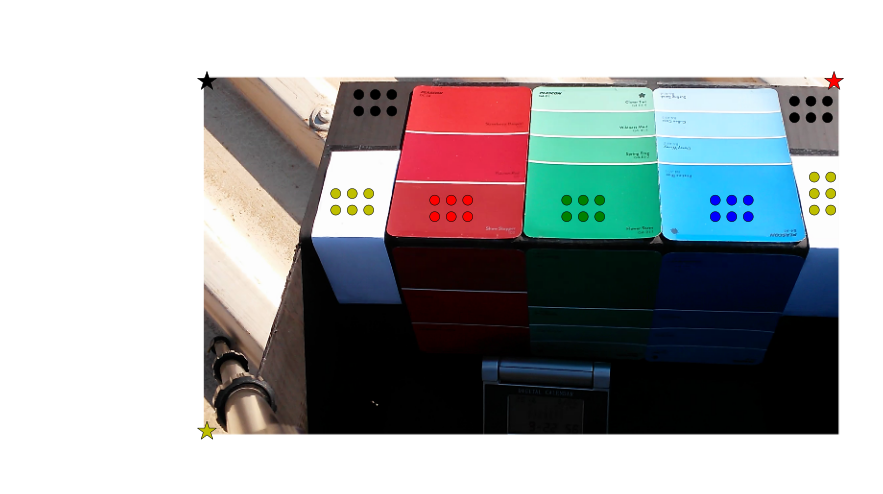

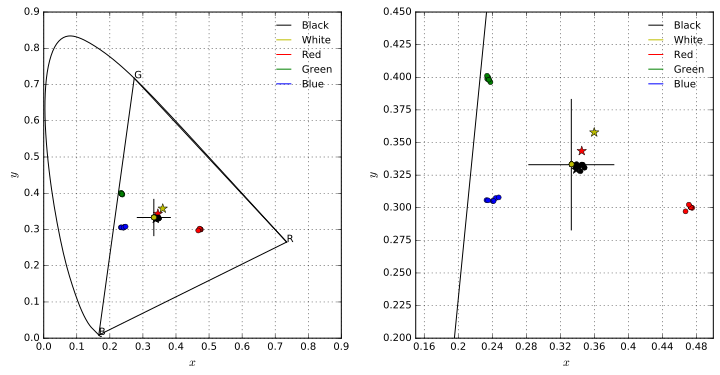

In [60]:
# define the pixel sample coordinates
colset = ['k','y','r','g','b']
labels = ['Black','White','Red','Green','Blue']
smplpts = [
    [   [470,50],[520,50],[570,50],[470,100],[520,100],[570,100], 
        [1790,70],[1840,70],[1890,70],[1790,120],[1840,120],[1890,120],],
    [   [400,350],[450,350],[500,350],[400,400],[450,400],[500,400],
        [1850,350],[1850,300],[1900,350],[1850,400], [1900,300],[1900,400],],
    [   [700,370],[750,370],[800,370],[700,420],[750,420],[800,420],],
    [   [1100,370],[1150,370],[1200,370],[1100,420],[1150,420],[1200,420],],
    [   [1550,370],[1600,370],[1650,370],[1550,420],[1600,420],[1650,420],],
        ]

#define the calibration coordinates to verify orientation and origin
calpts = [[10,10],[10, 1070],[1910,10]]

#load the picture
picture = np.array(PIL.Image.open('images/092257image-0197.png').convert('RGB'))

cropwin = [0.15,0.5,0.2,0.45]
singlePictureAnalysis(picture,calpts,smplpts,colset,labels,cropwin)

In [259]:
fdate = '2016-06-25'
xlsfilename = 'data/atmocolcoeff-{}.xlsx'.format(fdate)
if not os.path.exists(xlsfilename):
    # this part of the code requires the sequence of image files and will not run without
    fpath = '../../SMEOS-2016/colour-coords/data/Colour/{}/'.format(fdate)
    # filenames = ryfiles.listFiles(fpath, patterns='06123*.png', recurse=1, return_folders=0, useRegex=False)
    # filenames = ryfiles.listFiles(fpath, patterns='06394*.png', recurse=1, return_folders=0, useRegex=False)
    filenames = ryfiles.listFiles(fpath, patterns='*.png', recurse=1, return_folders=0, useRegex=False)
    filenames.sort()  
    cols = ['Zone','x','y','r','g','b','dtime','date','stime']
    dfXYrgb = pd.DataFrame()
    for ifi, filename in enumerate(filenames):
        stime = filename.split('\\')[-1][0:6]
        sdate = filename.split('\\')[-2]
        dtime = (3600*float(stime[0:2]) + 60*float(stime[2:4]) + float(stime[4:6]))/3600.
        if ifi%50 == 0:
            print('{}  --  {}'.format(dtime,filename))
        picture = np.array(PIL.Image.open(filename).convert('RGB'))
        for i,(item,label) in enumerate(zip(smplpts,labels)):
            for point in item:
                xy = rychroma.CIErgbCIExy(np.asarray([picture[point[1],point[0],0], 
                                                  picture[point[1],point[0],1], 
                                                  picture[point[1],point[0],2]]))
                res = [label,xy[0,0],xy[0,1],picture[point[1],point[0],0], 
                                                  picture[point[1],point[0],1], 
                                                  picture[point[1],point[0],2],dtime,fdate,stime] 
                dfXYrgb = dfXYrgb.append(pd.DataFrame([res],columns=cols),ignore_index=True)

    dfXYrgb.to_excel(xlsfilename,sheet_name='rgbxy',float_format='%14.7e',na_rep=-1)
    # print(dfXYrgb)    
else:
    dfXYrgb = pd.read_excel(xlsfilename,sheet_name='rgbxy')
    dfXYrgb['x'].replace(-1.0,np.nan,inplace=True)
    dfXYrgb['y'].replace(-1.0,np.nan,inplace=True)
print(dfXYrgb.shape)
print(dfXYrgb.iloc[dfXYrgb.shape[0]/2:dfXYrgb.shape[0]/2+10])

6.20972222222  --  ..\..\SMEOS-2016\colour-coords\data\Colour\2016-06-25\061235image-0001.png
7.01916666667  --  ..\..\SMEOS-2016\colour-coords\data\Colour\2016-06-25\070109image-0051.png
7.82833333333  --  ..\..\SMEOS-2016\colour-coords\data\Colour\2016-06-25\074942image-0101.png
8.63777777778  --  ..\..\SMEOS-2016\colour-coords\data\Colour\2016-06-25\083816image-0151.png
9.44722222222  --  ..\..\SMEOS-2016\colour-coords\data\Colour\2016-06-25\092650image-0201.png
10.2566666667  --  ..\..\SMEOS-2016\colour-coords\data\Colour\2016-06-25\101524image-0251.png
11.0658333333  --  ..\..\SMEOS-2016\colour-coords\data\Colour\2016-06-25\110357image-0301.png
11.8752777778  --  ..\..\SMEOS-2016\colour-coords\data\Colour\2016-06-25\115231image-0351.png
12.6847222222  --  ..\..\SMEOS-2016\colour-coords\data\Colour\2016-06-25\124105image-0401.png
13.4938888889  --  ..\..\SMEOS-2016\colour-coords\data\Colour\2016-06-25\132938image-0451.png
14.3033333333  --  ..\..\SMEOS-2016\colour-coords\data\Colou

In [178]:
# to process the temporal data
# remove all rows with NaN
dfXrNonan = dfXYrgb.dropna()
# get mean of the multiple samples
dfXrmean = pd.DataFrame()    
dfXrmean['xmean'] = dfXrNonan.groupby(['Zone','dtime'])['x'].mean()
dfXrmean['ymean'] = dfXrNonan.groupby(['Zone','dtime'])['y'].mean()
dfXrmean['rmean'] = dfXrNonan.groupby(['Zone','dtime'])['r'].mean()
dfXrmean['gmean'] = dfXrNonan.groupby(['Zone','dtime'])['g'].mean()
dfXrmean['bmean'] = dfXrNonan.groupby(['Zone','dtime'])['b'].mean()
dfXrmean.reset_index(inplace=True)  
print(dfXrmean.head())
uZones = dfXrmean['Zone'].unique()
print(uZones)


    Zone     dtime     xmean     ymean     rmean     gmean     bmean
0  Black  6.517222  0.313474  0.461360  0.666667  1.000000  0.666667
1  Black  6.533333  0.318506  0.304482  1.600000  1.600000  2.400000
2  Black  6.549722  0.302369  0.260865  2.666667  2.666667  4.666667
3  Black  6.565833  0.314511  0.307478  4.272727  4.909091  6.636364
4  Black  6.581944  0.316482  0.318888  5.916667  7.416667  8.833333
[u'Black' u'Blue' u'Green' u'Red' u'White']


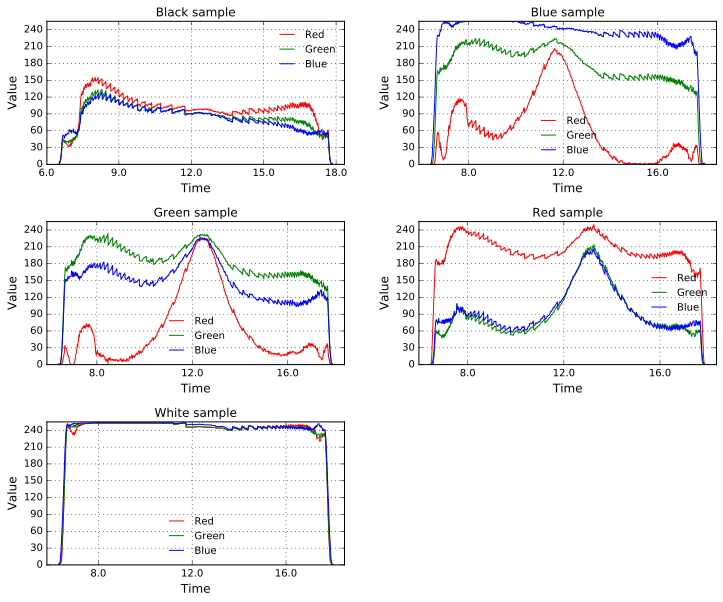

In [180]:
# to plot the temporal RGB values
p = ryplot.Plotter(1,0.5+len(uZones)/2.,2,figsize=(12,2*len(uZones)))
for iz,zone in enumerate(uZones): 
    p.buildPlotCol(['r','g','b'])
    for clr,label in zip(['rmean','gmean','bmean'],['Red','Green','Blue']):
        val = dfXrmean[dfXrmean['Zone']==zone][clr]
        tim = dfXrmean[dfXrmean['Zone']==zone]['dtime']
        p.plot(1+iz,tim,val,'{} sample'.format(zone),'Time','Value',label=[label],
               pltaxis=[np.min(tim)-.5, np.max(tim)+.5,0,255],maxNX=5)

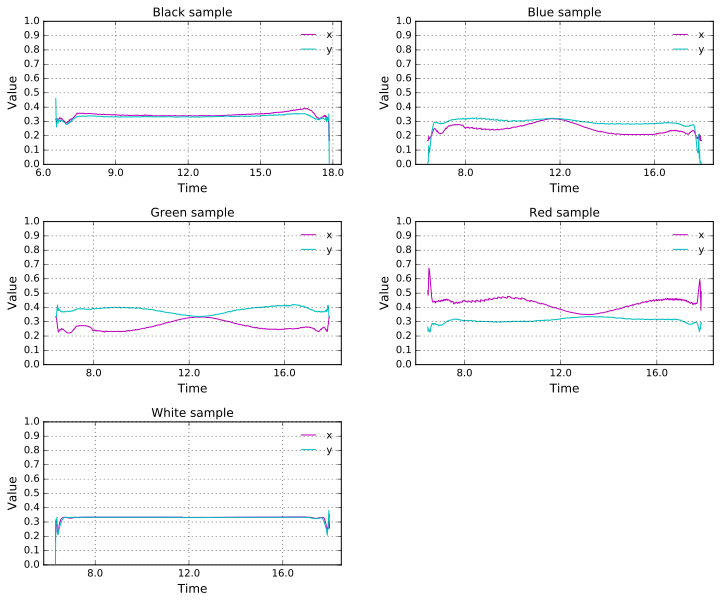

In [181]:
# to plot the temporal xy values
q = ryplot.Plotter(2,0.5+len(uZones)/2.,2,figsize=(12,2*len(uZones)))
for iz,zone in enumerate(uZones): 
    q.buildPlotCol(['m','c'])
    for clr,label in zip(['xmean','ymean'],['x','y']):
        val = dfXrmean[dfXrmean['Zone']==zone][clr]
        tim = dfXrmean[dfXrmean['Zone']==zone]['dtime']
        q.plot(1+iz,tim,val,'{} sample'.format(zone),'Time','Value',label=[label],
               pltaxis=[np.min(tim)-.5, np.max(tim)+.5,0,1],maxNX=5)
        

In [264]:
# to plot the temporal sequence on the xy diagram

def clktimefromdectime(dectime):
    from math import floor
    hours = floor(dectime)
    minutes = floor((dectime*3600-hours*3600)/60)
    seconds = floor(dectime*3600 - minutes*60 - hours*3600)
    return('{:.0f}:{:.0f}:{:.0f}'.format(hours, minutes,seconds))

def sequenceAnalysis(dfXrmean,cropwin,doAchro=True,doRGB=True,reject=[0,0]):

    #prepare for plotting
    q = ryplot.Plotter(2,1,2,figsize=(12,6))

    # plot monochromatic horseshoe
    q.plot(1, xm, ym, '', '$x$', '$y$', plotCol=['k-'], pltaxis=[0.,0.9,0.,0.9])
    q.plot(2, xm, ym, '',' $x$', '$y$', plotCol=['k-'], pltaxis=cropwin)

    if doAchro:
        # plot achromatic point - no colour
        q.plot(1, np.asarray([0.333, 0.333]), np.asarray([0.283, 0.383]), plotCol=['k-'])
        q.plot(1, np.asarray([0.283, 0.383]), np.asarray([0.333, 0.333]), plotCol=['k-'])
        q.plot(2, np.asarray([0.333, 0.333]), np.asarray([0.283, 0.383]), plotCol=['k-'])
        q.plot(2, np.asarray([0.283, 0.383]), np.asarray([0.333, 0.333]), plotCol=['k-'])

    if doRGB:
        #plot the CIE RGB triangle: R, G, B
        rgbTri = np.asarray([[255,0,0],[0,255,0],[0,0,255]])    
        xy = rychroma.CIErgbCIExy(rgbTri)
        for i,ch in zip([0,1,2],['R','G','B']):
            q.plot(1, np.asarray([xy[i,0], xy[(i+1)%3,0]]), np.asarray([xy[i,1], xy[(i+1)%3,1]]), plotCol=['k-'])
            q.plot(2, np.asarray([xy[i,0], xy[(i+1)%3,0]]), np.asarray([xy[i,1], xy[(i+1)%3,1]]), plotCol=['k-'])
            q.getSubPlot(1).text(xy[i,0], xy[i,1],ch)
    plotcol = {'Red':'r','Green':'g','Blue':'b','White':'m','Black':'k'}
    numdata = dfXrmean.shape[0]
    dfXrmean.sort_values(by=['dtime'],inplace=True)
    dfXrmeanfilt = dfXrmean.iloc[reject[0]:numdata-reject[1]]
    timSet = 'Time range: from {} to {}'.format(clktimefromdectime(np.min(dfXrmeanfilt['dtime'])),
                                                clktimefromdectime(np.max(dfXrmeanfilt['dtime'])))
    for iz,zone in enumerate(uZones): 
        q.buildPlotCol(['m','c','r','g','b'])
        valx = dfXrmeanfilt[dfXrmeanfilt['Zone']==zone]['xmean']
        valy = dfXrmeanfilt[dfXrmeanfilt['Zone']==zone]['ymean']
        q.plot(1,valx,valy,timSet,label=[zone],plotCol=plotcol[zone])
        q.plot(2,valx,valy,timSet,label=[zone],plotCol=plotcol[zone])
            


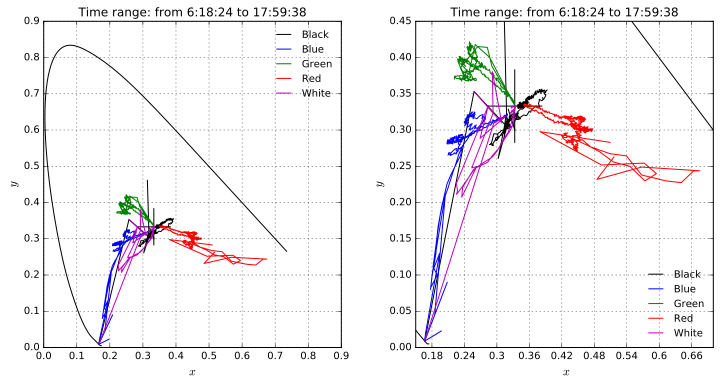

In [271]:
cropwin = [0.15,0.7,0.0,0.45]
sequenceAnalysis(dfXrmean,cropwin,doAchro=True,doRGB=False,reject=[0,0])            

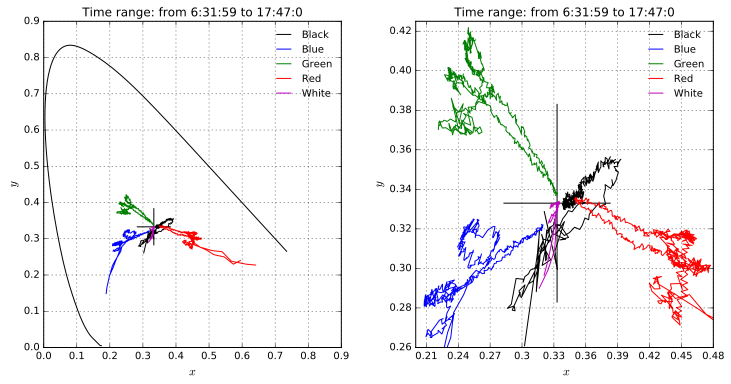

In [274]:
cropwin = [0.2,0.48,0.26,0.425]
sequenceAnalysis(dfXrmean,cropwin,doAchro=True,doRGB=False,reject=[40,40])            

## Conclusion

*  Considering only the direct sun irradiance, there is indeed a pronounced shift towards yellow/red at sun zenith angles exceeding 60 degrees.  At small and intermediate zenith angles and for good visibility atmospheres the shift is towards yellow.   For the combined effect of large zenith angles and low visibility atmospheres the shift is very strongly towards red.

*  Human experience indicate that we tend to compensate automatically for colour shift (white balance) when viewing the real world. However, when viewing a computer screen or a picture, we do not perform white balance, possibly because we do not view the object in the picture in the same context as a fully immersive real-world view.

* With the assumption of visibility better than 23 km, it should be feasibly to calculate  a colour correction for a given sun zenith angle.  The sun zenith angle can be readily calculated from the date, time of day, and geographic location.

* If the visibility is very low (i.e., 5 km) and at large zenith angles, the shift is so strong towards red that it is not feasible to correct the shift accurately.  The original colours in the image are distorted so severely that manipulation would only degrade the image.

## Python and [module versions, and dates](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [58]:
%load_ext version_information
%version_information pandas, numpy, scipy, matplotlib

Software versions
Python 2.7.12 64bit [MSC v.1500 64 bit (AMD64)]
IPython 4.2.0
OS Windows 7 6.1.7601 SP1
pandas 0.18.1
numpy 1.11.1
scipy 0.17.1
matplotlib 1.5.1
Tue Jul 19 12:21:41 2016 South Africa Standard Time